In [ ]:

# Clone repo
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN

# Install deps (keeps default Colab torch 2.x & torchvision 0.23.x)
!pip install basicsr facexlib gfpgan realesrgan

# For upload widgets
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

fatal: destination path 'Real-ESRGAN' already exists and is not an empty directory.
/content/Real-ESRGAN
  Using cached realesrgan-0.3.0-py3-none-any.whl.metadata (17 kB)
Using cached realesrgan-0.3.0-py3-none-any.whl (26 kB)
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:

# Create a fake version.py so import works
with open("/content/Real-ESRGAN/realesrgan/version.py", "w") as f:
    f.write("__version__ = '0.3.0'")

In [ ]:
!pip uninstall -y realesrgan

In [ ]:
!pip uninstall -y realesrgan

Found existing installation: realesrgan 0.3.0
Uninstalling realesrgan-0.3.0:
  Successfully uninstalled realesrgan-0.3.0


In [ ]:

import sys
sys.path.append("/content/Real-ESRGAN")   # repo path
from realesrgan import RealESRGANer

In [ ]:
model = RealESRGAN(
    scale=scale,
    model_path=weight_path,
    device=device,
    tile=0,
    tile_pad=10,
    pre_pad=0,
    half=True if device == 'cuda' else False,
)

NameError: name 'RealESRGAN' is not defined

In [ ]:

import fileinput

target_file = "/usr/local/lib/python3.12/dist-packages/basicsr/data/degradations.py"

with fileinput.FileInput(target_file, inplace=True) as file:
    for line in file:
        # Fix wrong import
        if "from torchvision.transforms import functional_tensor" in line:
            print("import torchvision.transforms.functional as F")
        # Replace all calls to functional_tensor.* with F.*
        elif "functional_tensor." in line:
            print(line.replace("functional_tensor.", "F."), end="")
        else:
            print(line, end="")

print("✅ basicsr patched to use torchvision.transforms.functional (F)")

✅ basicsr patched to use torchvision.transforms.functional (F)


In [ ]:

import fileinput

target_file = "/usr/local/lib/python3.12/dist-packages/basicsr/data/degradations.py"

with fileinput.FileInput(target_file, inplace=True) as file:
    for line in file:
        # If it's trying to import from torchvision.transforms.F → fix it
        if "from torchvision.transforms.F import" in line:
            print(line.replace("from torchvision.transforms.F import",
                               "from torchvision.transforms.functional import"), end="")
        # If it's importing functional_tensor → fix it to functional
        elif "from torchvision.transforms import functional_tensor" in line:
            print("import torchvision.transforms.functional as F")
        # Fix any calls
        elif "functional_tensor." in line:
            print(line.replace("functional_tensor.", "F."), end="")
        else:
            print(line, end="")

print("✅ Fixed basicsr to use torchvision.transforms.functional correctly")

✅ Fixed basicsr to use torchvision.transforms.functional correctly


FileUpload(value={'Gz_RXWgWgAA2gl2.jpeg': {'metadata': {'name': 'Gz_RXWgWgAA2gl2.jpeg', 'type': 'image/jpeg', …

Uploaded image: Gz_RXWgWgAA2gl2.jpeg, size: (963, 1200)


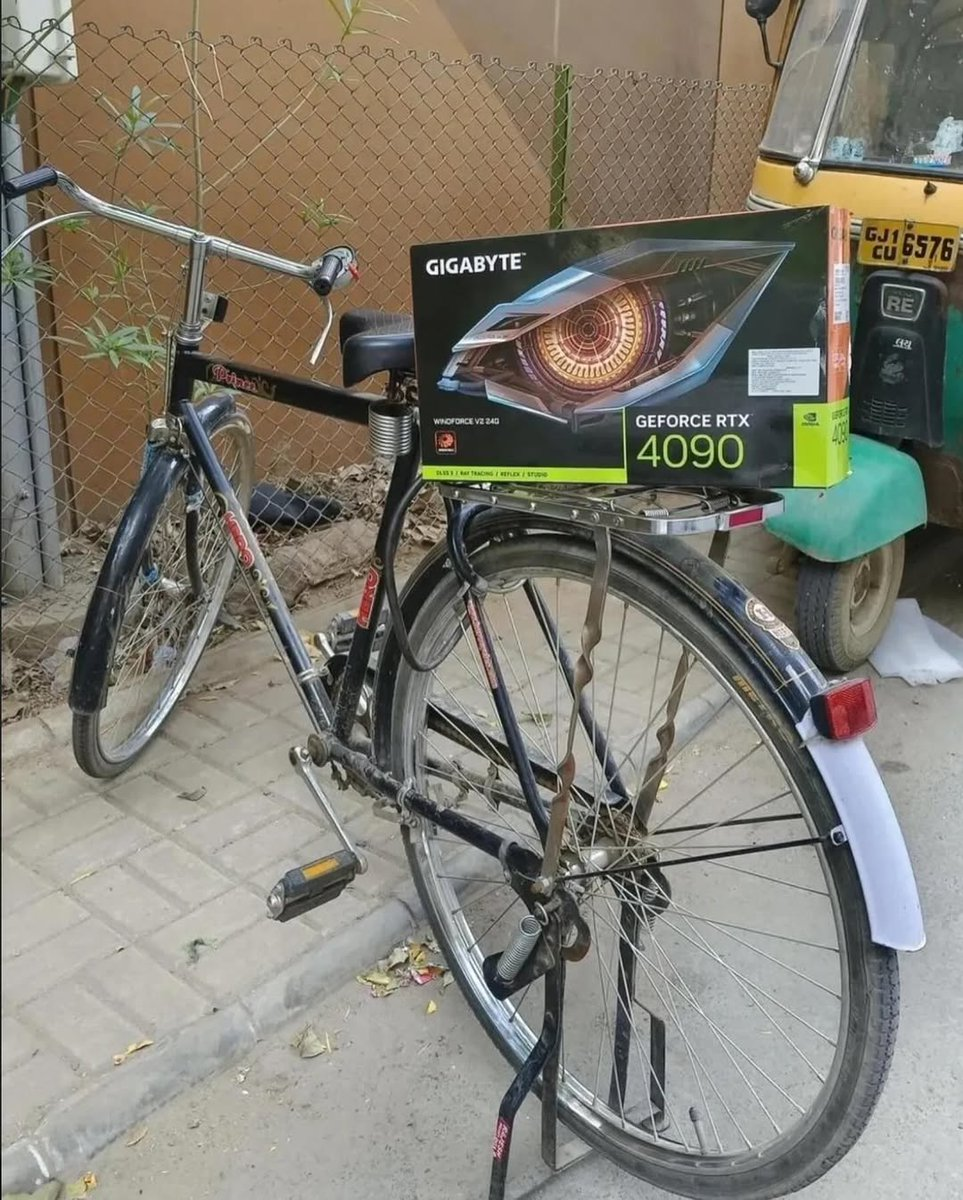

Upscaling with Real-ESRGAN 4x model...


AttributeError: 'NoneType' object has no attribute 'load_state_dict'

In [ ]:

# Install dependencies (run once per session)
!pip uninstall -y realesrgan
!git clone https://github.com/xinntao/Real-ESRGAN.git /content/Real-ESRGAN
!pip install basicsr facexlib gfpgan
!pip install -r /content/Real-ESRGAN/requirements.txt
!python /content/Real-ESRGAN/setup.py develop

# -------------------------------
# Imports
import torch
from PIL import Image
import numpy as np
import io
from IPython.display import display, clear_output
import ipywidgets as widgets
import sys, os

# Add Real-ESRGAN repo path
REPO_PATH = "/content/Real-ESRGAN"
if REPO_PATH not in sys.path:
    sys.path.append(REPO_PATH)

# Import RealESRGANer (repo version)
from realesrgan import RealESRGANer

# Device config (T4 GPU if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Model weights (downloaded if missing)
weights = {
    2: os.path.join(REPO_PATH, 'weights', 'RealESRGAN_x2plus.pth'),
    4: os.path.join(REPO_PATH, 'weights', 'RealESRGAN_x4plus.pth'),
    8: os.path.join(REPO_PATH, 'weights', 'RealESRGAN_x8plus.pth'),
}
os.makedirs(os.path.join(REPO_PATH, 'weights'), exist_ok=True)

# -------------------------------
# Upload widget
upload = widgets.FileUpload(accept='image/*', multiple=False)
display(upload)

# Buttons
btn_2x = widgets.Button(description="Upscale 2x")
btn_4x = widgets.Button(description="Upscale 4x")
btn_8x = widgets.Button(description="Upscale 8x")
buttons = widgets.HBox([btn_2x, btn_4x, btn_8x])
display(buttons)

uploaded_image = None

def on_upload_change(change):
    global uploaded_image
    if upload.value:
        for name, file_info in upload.value.items():
            img_bytes = file_info['content']
            uploaded_image = Image.open(io.BytesIO(img_bytes)).convert("RGB")
            clear_output(wait=True)
            display(upload)
            display(buttons)
            print(f"Uploaded image: {name}, size: {uploaded_image.size}")
            display(uploaded_image)

upload.observe(on_upload_change, names='value')

# -------------------------------
# Upscale function
def upscale(scale):
    global uploaded_image
    if uploaded_image is None:
        print("Please upload an image first!")
        return

    weight_path = weights.get(scale, None)
    if weight_path is None:
        print(f"No weights defined for {scale}x.")
        return

    print(f"Upscaling with Real-ESRGAN {scale}x model...")

    # ✅ Correct initialization (no fp32)
    model = RealESRGANer(
        scale=scale,
        model_path=weight_path,
        device=device,
        tile=0,
        tile_pad=10,
        pre_pad=0,
        half=True if device == 'cuda' else False,
    )

    img_np = np.array(uploaded_image)

    with torch.no_grad():
        output, _ = model.enhance(img_np, outscale=scale)

    output_img = Image.fromarray(output)

    clear_output(wait=True)
    display(upload)
    display(buttons)
    print("Original Image:")
    display(uploaded_image)
    print(f"Upscaled Image ({scale}x):")
    display(output_img)

# -------------------------------
# Bind buttons
btn_2x.on_click(lambda x: upscale(2))
btn_4x.on_click(lambda x: upscale(4))
btn_8x.on_click(lambda x: upscale(8))

FileUpload(value={'Gz_RXWgWgAA2gl2.jpeg': {'metadata': {'name': 'Gz_RXWgWgAA2gl2.jpeg', 'type': 'image/jpeg', …

Original Image:


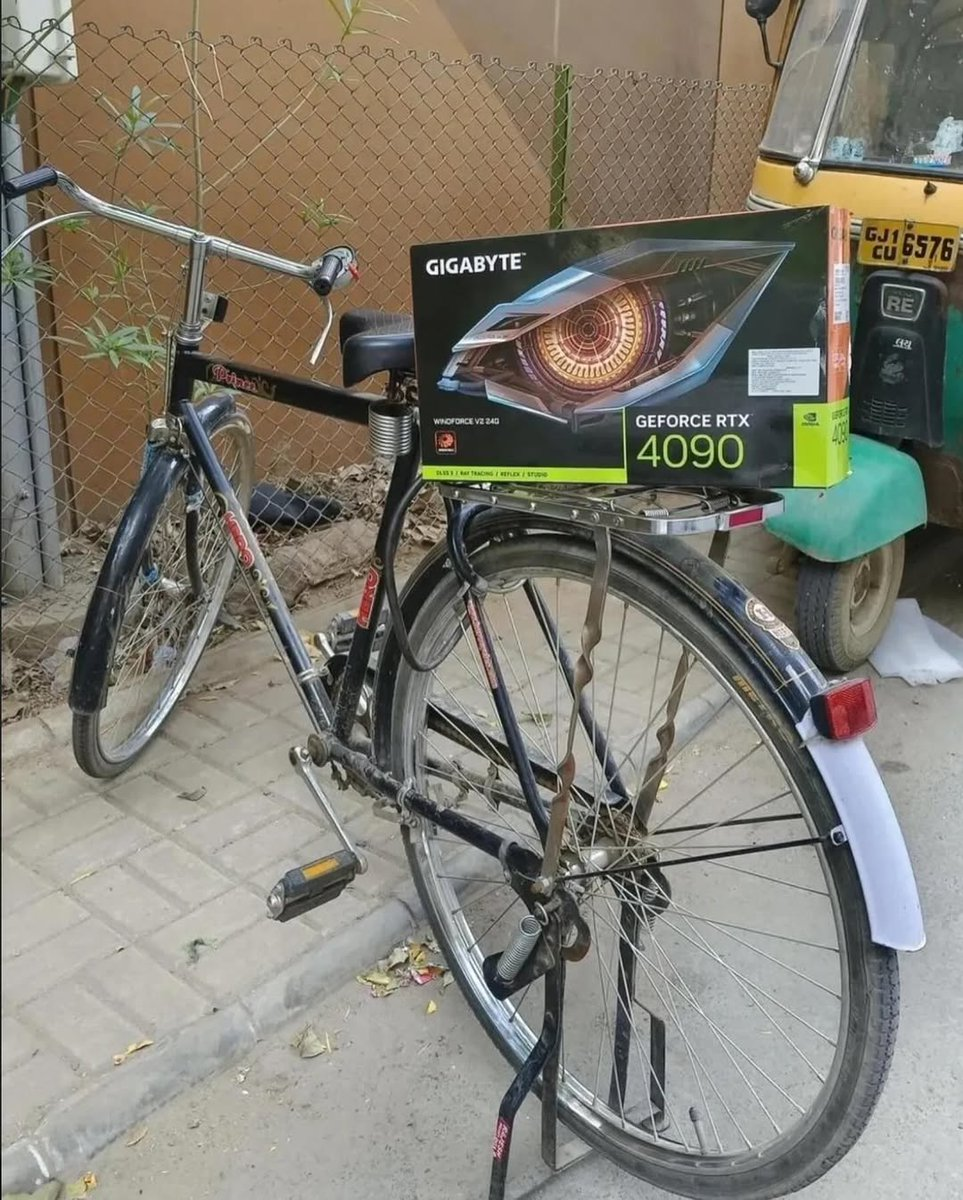

Upscaled Image (4x) — saved at /content/upscaled_x4.png


In [ ]:

# ============================================
# 1. Install dependencies (run once per session)
# ============================================
!pip uninstall -y realesrgan
!git clone https://github.com/xinntao/Real-ESRGAN.git /content/Real-ESRGAN
!pip install basicsr facexlib gfpgan
!pip install -r /content/Real-ESRGAN/requirements.txt
!python /content/Real-ESRGAN/setup.py develop

# Download model weights
!mkdir -p /content/Real-ESRGAN/weights
!wget -nc -O /content/Real-ESRGAN/weights/RealESRGAN_x2plus.pth https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x2plus.pth
!wget -nc -O /content/Real-ESRGAN/weights/RealESRGAN_x4plus.pth https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth
!wget -nc -O /content/Real-ESRGAN/weights/RealESRGAN_x8plus.pth https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.0/RealESRGAN_x8plus.pth

# ============================================
# 2. Imports
# ============================================
import torch
from PIL import Image
import numpy as np
import io
from IPython.display import display, clear_output
import ipywidgets as widgets
import sys, os

# Add Real-ESRGAN repo path
REPO_PATH = "/content/Real-ESRGAN"
if REPO_PATH not in sys.path:
    sys.path.append(REPO_PATH)

# Import ESRGAN utils
from realesrgan import RealESRGANer
from basicsr.archs.rrdbnet_arch import RRDBNet

# Device config (T4 GPU if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Model weights dictionary
weights = {
    2: os.path.join(REPO_PATH, 'weights', 'RealESRGAN_x2plus.pth'),
    4: os.path.join(REPO_PATH, 'weights', 'RealESRGAN_x4plus.pth'),
    8: os.path.join(REPO_PATH, 'weights', 'RealESRGAN_x8plus.pth'),
}

# ============================================
# 3. Upload widget + buttons
# ============================================
upload = widgets.FileUpload(accept='image/*', multiple=False)
display(upload)

btn_2x = widgets.Button(description="Upscale 2x")
btn_4x = widgets.Button(description="Upscale 4x")
btn_8x = widgets.Button(description="Upscale 8x")
buttons = widgets.HBox([btn_2x, btn_4x, btn_8x])
display(buttons)

uploaded_image = None

def on_upload_change(change):
    global uploaded_image
    if upload.value:
        for name, file_info in upload.value.items():
            img_bytes = file_info['content']
            uploaded_image = Image.open(io.BytesIO(img_bytes)).convert("RGB")
            clear_output(wait=True)
            display(upload)
            display(buttons)
            print(f"Uploaded image: {name}, size: {uploaded_image.size}")
            display(uploaded_image)

upload.observe(on_upload_change, names='value')

# ============================================
# 4. Upscale function
# ============================================
def upscale(scale):
    global uploaded_image
    if uploaded_image is None:
        print("Please upload an image first!")
        return

    weight_path = weights.get(scale, None)
    if weight_path is None or not os.path.exists(weight_path):
        print(f"No weights found for {scale}x at {weight_path}")
        return

    print(f"Upscaling with Real-ESRGAN {scale}x model...")

    # ✅ Explicit model definition (avoids NoneType error)
    model_rrdb = RRDBNet(
        num_in_ch=3, num_out_ch=3, num_feat=64,
        num_block=23, num_grow_ch=32, scale=scale
    )

    model = RealESRGANer(
        scale=scale,
        model_path=weight_path,
        model=model_rrdb,      # 👈 explicitly pass RRDBNet
        device=device,
        tile=0,
        tile_pad=10,
        pre_pad=0,
        half=True if device == 'cuda' else False,
    )

    img_np = np.array(uploaded_image)

    with torch.no_grad():
        output, _ = model.enhance(img_np, outscale=scale)

    output_img = Image.fromarray(output)

    # Save result
    save_path = f"/content/upscaled_x{scale}.png"
    output_img.save(save_path)

    clear_output(wait=True)
    display(upload)
    display(buttons)
    print("Original Image:")
    display(uploaded_image)
    print(f"Upscaled Image ({scale}x) — saved at {save_path}")
    display(output_img)

# ============================================
# 5. Bind buttons
# ============================================
btn_2x.on_click(lambda x: upscale(2))
btn_4x.on_click(lambda x: upscale(4))
btn_8x.on_click(lambda x: upscale(8))

In [ ]:

from basicsr.archs.rrdbnet_arch import RRDBNet

def upscale(scale):
    global uploaded_image
    if uploaded_image is None:
        print("Please upload an image first!")
        return

    weight_path = weights.get(scale, None)
    if weight_path is None or not os.path.exists(weight_path):
        print(f"No weights found for {scale}x at {weight_path}")
        return

    print(f"Upscaling with Real-ESRGAN {scale}x model...")

    # ✅ Define model explicitly
    model_rrdb = RRDBNet(
        num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23,
        num_grow_ch=32, scale=scale
    )

    model = RealESRGANer(
        scale=scale,
        model_path=weight_path,
        model=model_rrdb,     # 👈 Explicitly pass RRDBNet
        device=device,
        tile=0,
        tile_pad=10,
        pre_pad=0,
        half=True if device == 'cuda' else False,
    )

    img_np = np.array(uploaded_image)

    with torch.no_grad():
        output, _ = model.enhance(img_np, outscale=scale)

    output_img = Image.fromarray(output)

    clear_output(wait=True)
    display(upload)
    display(buttons)
    print("Original Image:")
    display(uploaded_image)
    print(f"Upscaled Image ({scale}x):")
    display(output_img)

In [ ]:

# 🔹 Download model weights (run once)
!mkdir -p /content/Real-ESRGAN/weights
!wget -nc -O /content/Real-ESRGAN/weights/RealESRGAN_x2plus.pth https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x2plus.pth
!wget -nc -O /content/Real-ESRGAN/weights/RealESRGAN_x4plus.pth https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth
!wget -nc -O /content/Real-ESRGAN/weights/RealESRGAN_x8plus.pth https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.0/RealESRGAN_x8plus.pth

--2025-09-10 14:15:09--  https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x2plus.pth
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-09-10 14:15:10 ERROR 404: Not Found.

--2025-09-10 14:15:10--  https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/387326890/08f0e941-ebb7-48f0-9d6a-73e87b710e7e?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-10T14%3A55%3A16Z&rscd=attachment%3B+filename%3DRealESRGAN_x4plus.pth&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-10T13%3A55%3A